In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data, accuracy_plot, calc_metrics
### input
folder = 'http://192.168.1.30:8333/ai4sh-landmasked/model_benchmark'
# from log_back_transform_rf import TreesRandomForestRegressor

prop_list = ['ocd','oc','bulk_density', 'ph_cacl2','ph_h2o','N','caco3','K','EC','P','CEC','texture1','texture2'] # unitl N everything has lightGBM models
space_list = ['log1p','log1p','normal', 'normal','normal','log1p','log1p','log1p','log1p','log1p','log1p','log1p','log1p'] # 
filt_list = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5] #5,5,5,5,

In [2]:
# set up
cv = GroupKFold(n_splits=5) 
rsl = []
prop = 'ocd'
space = 'log1p'
output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}'
tgt = f'{prop}_log1p'

# model
pathm = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/model_rf.{prop}_ccc.joblib'
model = joblib.load(pathm)
# model.n_jobs=90

# covariates
pathc = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt'
covs = read_features(pathc) 

# data
train = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_train.csv',low_memory=False)
train = train.dropna(subset=covs+[tgt],how='any')
test = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_test.csv',low_memory=False)
test = test.dropna(subset=covs+[tgt],how='any')

In [3]:

# 5-fold spatial cv
ttprint('CV')
y_cv = cross_val_predict(model, train[covs], train[tgt], cv=cv, groups=train['tile_id'], n_jobs=60)
mae_cv, medae_cv, mape_cv, ccc_cv, r2_cv, bias_cv = calc_metrics(train[tgt], y_cv, space)
# r2_cv, mae_cv, ccc_cv = accuracy_plot(train[tgt], y_cv, space, '5-fold spatial CV', output_folder=output_folder, show_range = [show_low, show_high], vmax=10) 
     
rsl.append({
    'method': '5-fold spatial CV',
    'MAE': mae_cv,
    'MAPE':mape_cv,
    'MedAE': medae_cv,
    'R2': r2_cv,
    'CCC': ccc_cv,
    'bias': bias_cv
    # 'cv_time (s)': cv_time
})

# test
ttprint('test')
model.fit(train[covs], train[tgt])
y_val = model.predict(test[covs])
mae_val, medae_val, mape_val, ccc_val, r2_val, bias_val = calc_metrics(test[tgt], y_val, space)
# r2_val, mae_val, ccc_val = accuracy_plot(test[tgt], y_val, space, 'Independent test', output_folder=output_folder,show_range = [show_low, show_high], vmax=3) 
# error_spatial_plot(test[tgt], y_val, test['lat'], test['lon'], figure_name+ '-test', output_folder=output_folder)
# sorted_plot(test[tgt],y_val, figure_name+ '-test', output_folder=output_folder)

rsl.append({
    'method': 'individual validation data',
    'MAE': mae_val,
    'MAPE': mape_val,
    'MedAE': medae_val,
    'R2': r2_val,
    'CCC': ccc_val,
    'bias': bias_val
    # 'cv_time (s)': cv_time
})
rsl = pd.DataFrame(rsl)
rsl

[08:57:14] CV
[08:57:41] test


,method,MAE,MAPE,MedAE,R2,CCC,bias
0,5-fold spatial CV,8.645408,0.538194,4.263586,0.709098,0.827211,-2.959056
1,individual validation data,7.743001,0.448666,3.513991,0.776355,0.868530,-3.160186


In [5]:
import pickle

with open('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/predictions_evaluation.pkl', 'wb') as file:
    pickle.dump({'y_cv': y_cv, 'y_val': y_val}, file)

print("Predictions saved to 'predictions.pkl'.")

Predictions saved to 'predictions.pkl'.


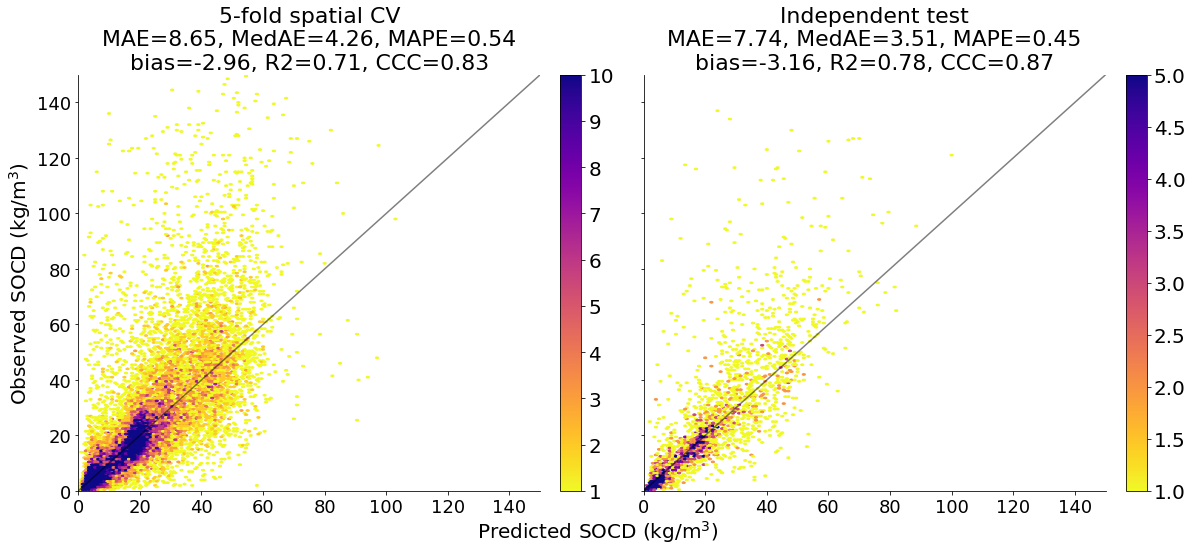

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming mae_cv, r2_cv, ccc_cv, y_cv, train[prop], mae_val, r2_val, ccc_val, y_val, test[prop] are already defined

show_low = 0
show_high = 150

x_min, x_max = 0, 150
y_min, y_max = 0, 150

fig, axs = plt.subplots(1, 2, figsize=(17, 8))  # 17x8 inches figure with two subplots

# Update rcParams for global font size settings
plt.rcParams.update({'font.size': 20})

# Plot the first accuracy plot
axs[0].set_title(f'5-fold spatial CV\nMAE={mae_cv:.2f}, MedAE={medae_cv:.2f}, MAPE={mape_cv:.2f}\nbias={bias_cv:.2f}, R2={r2_cv:.2f}, CCC={ccc_cv:.2f}', fontsize=22)
hb1 = axs[0].hexbin(np.expm1(y_cv), train[prop], gridsize=(150, 150), extent=[x_min, x_max, y_min, y_max], cmap='plasma_r', mincnt=1, vmax=10)  # Change 'plasma_r' to 'plasma'
# axs[0].set_xlabel('Predicted SOCD (mg/cm$^3$)', fontsize=20)
axs[0].set_ylabel('Observed SOCD (kg/m$^3$)', fontsize=20)
axs[0].set_aspect('auto', adjustable='box')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].plot([show_low, show_high], [show_low, show_high], "-k", alpha=.5)
axs[0].tick_params(labelsize=18)
axs[0].set_xlim([show_low, show_high])
axs[0].set_ylim([show_low, show_high])

# Plot the second accuracy plot
axs[1].set_title(f'Independent test\nMAE={mae_val:.2f}, MedAE={medae_val:.2f}, MAPE={mape_val:.2f}\nbias={bias_val:.2f}, R2={r2_val:.2f}, CCC={ccc_val:.2f}', fontsize=22)
hb2 = axs[1].hexbin(np.expm1(y_val), test[prop], gridsize=(150, 150), extent=[x_min, x_max, y_min, y_max], cmap='plasma_r', mincnt=1, vmax=5)  # Change 'plasma_r' to 'plasma'
# Hide y-axis label on the right plot
# axs[1].set_ylabel('Observed SOCD (mg/cm$^3$)', fontsize=20)
axs[1].set_aspect('auto', adjustable='box')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].plot([show_low, show_high], [show_low, show_high], "-k", alpha=.5)
axs[1].tick_params(labelsize=18)
axs[1].set_xlim([show_low, show_high])
axs[1].set_ylim([show_low, show_high])

# Remove the right y-axis labels
axs[1].tick_params(axis='y', labelleft=False)

# Set a shared x-label for both subplots
fig.text(0.5, 0.04, 'Predicted SOCD (kg/m$^3$)', ha='center', fontsize=20)

# Create a colorbar for each subplot
cbar1 = fig.colorbar(hb1, ax=axs[0], fraction=0.046, pad=0.04)
cbar2 = fig.colorbar(hb2, ax=axs[1], fraction=0.046, pad=0.04)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig(f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/plot_ocd_accuracy.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Show the plot if desired
plt.show()


In [19]:
cal_size = 3678
train_size = 16124
test_size = 2626

In [23]:
cal_size/(train_size+test_size+cal_size)

0.16399143927233814

In [24]:
train_size/(train_size+test_size+cal_size)

0.7189227751025504

In [27]:
test_size/train_size

0.1628628131977177

In [9]:
y_val = np.expm1(y_val)

In [12]:
depth = [0,20,50,100]

for idep in [1,2,3]:
    temp = test.loc[(test['hzn_dep']>depth[idep-1]) & (test['hzn_dep']<=depth[idep])]
    print('mean')
    print(temp['ocd'].mean(), temp['pred'].mean())
    
    print('median')
    print(temp['ocd'].median(), temp['pred'].median())

mean
31.955896085231416 28.49597020765751
median
25.8048 25.381888992249586
mean
14.932767724867723 11.920411918284737
median
9.2353 9.056672870092058
mean
7.98452170940171 5.688685730440922
median
3.4066999999999994 3.98958681296583


### split training and test set first

In [21]:
# # data
# train = pd.read_csv(f'{output_folder}/benchmark_train.pnts_{prop}.csv',low_memory=False)
# # train = train.dropna(subset=covs+[tgt],how='any')
# test = pd.read_csv(f'{output_folder}/benchmark_test.pnts_{prop}.csv',low_memory=False)
# # test = test.dropna(subset=covs+[tgt],how='any')
# cal = pd.read_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',low_memory=False)
# # cal = cal.dropna(subset=covs+[tgt],how='any')

# tt = pd.concat([train,test])
# # tt = tt.loc[tt['tile_id'].notna()]
# train_tt, test_tt = train_test_split(tt, test_size=0.14, random_state=42)
# # from sklearn.model_selection import StratifiedShuffleSplit
# # sss = StratifiedShuffleSplit(n_splits=1, test_size=0.14, random_state=42)

# # for train_index, test_index in sss.split(tt, tt['tile_id']):
# #     train_tt = tt.iloc[train_index]
# #     test_tt = tt.iloc[test_index]


# train_tt.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_train.csv',index=False)
# test_tt.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_test.csv',index=False)